In [1]:
import tensorflow as tf
from keras import layers, models,Model
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import time
import seaborn as sns
from keras.layers import Input

# PART A

In [3]:
(train_data, train_label), (test_data, test_label) = cifar10.load_data()
train_data, valid_data, train_label, valid_label = train_test_split(train_data, train_label, test_size=0.2, random_state=42)

grey_train = tf.image.rgb_to_grayscale(train_data)
grey_valid = tf.image.rgb_to_grayscale(valid_data)
grey_test = tf.image.rgb_to_grayscale(test_data)

170508288/170498071 [==============================] - 2s 0us/step


In [4]:
grey_train=np.squeeze(np.array(grey_train)).reshape(40000,32*32)
grey_valid=np.squeeze(np.array(grey_valid)).reshape(10000,32*32)
grey_test=np.squeeze(np.array(grey_test)).reshape(10000,32*32)

In [5]:
train_data = np.array(grey_train) / 255.0
valid_data= np.array(grey_valid)/ 255.0
test_data = np.array(grey_test) / 255.0

In [6]:
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(40000, 1024)
(10000, 1024)
(10000, 1024)


In [7]:
train_label = tf.keras.utils.to_categorical(train_label,10)
test_label = tf.keras.utils.to_categorical(test_label,10)
valid_label = tf.keras.utils.to_categorical(valid_label,10)

In [8]:
from sklearn.utils.extmath import randomized_svd
U, S, Vt = randomized_svd(
                train_data,
                n_components=1024,
                n_iter="auto",
                random_state=None,
            )

In [9]:
eigs=S**2/(40000-1)

[0.8575358403901153, 0.027485699011575857, 0.016776874257231896, 0.008063427153957631, 0.006352227479221747, 0.005971350997803549, 0.004770382740474556, 0.004683554601813773, 0.0031592876275654725, 0.002863882070834792, 0.0023565820147810968, 0.0023214509474635088, 0.0021964121371886147, 0.0020157430696080927, 0.001801396246885926, 0.0015641881819587911, 0.0014244326259754943, 0.001302419394422044, 0.0012893984842803085, 0.0010982821946103536, 0.0010837664438089144, 0.001026702278354032, 0.000989786041073408, 0.0009754850635941319, 0.0008876653505047161, 0.0008616976917806642, 0.0008056256642795264, 0.0007365695658736963, 0.0007141904953384149, 0.0006856173495984945, 0.0006811973826031134, 0.0006363941333489444, 0.0005769803080433086, 0.0005685736558977167, 0.0005589398712947551, 0.0005464815439543046, 0.0005342067856154908, 0.0005047524915843892, 0.0005021362844772655, 0.0004916983926062119, 0.0004636822545080962, 0.00045873103057783446, 0.0004228286196180368, 0.0004199538646678267, 0

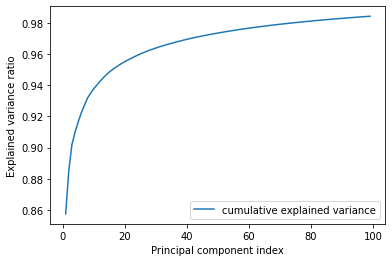

In [10]:
var_exp = [(i / sum(eigs)) for i in sorted(eigs, reverse=True)]
print(var_exp)
cum_var_exp = np.cumsum(var_exp)

plt.plot(range(1,100), cum_var_exp[0:99], 
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [16]:
# using first 77 components to transform data
train_img_pca = train_data@Vt[0:77,:].T
test_img_pca = test_data@Vt[0:77,:].T
val_img_pca = valid_data@Vt[0:77,:].T

In [21]:
print(train_img_pca.shape)
print(test_img_pca.shape)
print(val_img_pca.shape)

(40000, 77)
(10000, 77)
(10000, 77)


In [17]:
model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=(77,)))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1024)              79872     
                                                                 
 dense_9 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 10)                5130      
                                                                 
Total params: 1,659,402
Trainable params: 1,659,402
Non-trainable params: 0
_________________________________________________________________


In [18]:
# training the model
start_time=time.time()
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
fit_history = model.fit(train_img_pca, train_label, epochs=20,
                    validation_data=(val_img_pca, valid_label), batch_size=128)
stop_time=time.time()
print("\n training time:",stop_time-start_time)

Epoch 1/20
313/313 [==============================] - 3s 7ms/step - loss: 2.0000 - accuracy: 0.2819 - val_loss: 1.8861 - val_accuracy: 0.3400
Epoch 2/20
313/313 [==============================] - 2s 7ms/step - loss: 1.8293 - accuracy: 0.3510 - val_loss: 1.8289 - val_accuracy: 0.3544
Epoch 3/20
313/313 [==============================] - 2s 7ms/step - loss: 1.7549 - accuracy: 0.3790 - val_loss: 1.7466 - val_accuracy: 0.3844
Epoch 4/20
313/313 [==============================] - 2s 6ms/step - loss: 1.7030 - accuracy: 0.3996 - val_loss: 1.7273 - val_accuracy: 0.3872
Epoch 5/20
313/313 [==============================] - 2s 7ms/step - loss: 1.6620 - accuracy: 0.4112 - val_loss: 1.6954 - val_accuracy: 0.4048
Epoch 6/20
313/313 [==============================] - 2s 7ms/step - loss: 1.6163 - accuracy: 0.4254 - val_loss: 1.6907 - val_accuracy: 0.4081
Epoch 7/20
313/313 [==============================] - 3s 10ms/step - loss: 1.5898 - accuracy: 0.4346 - val_loss: 1.7113 - val_accuracy: 0.3964
Epoch

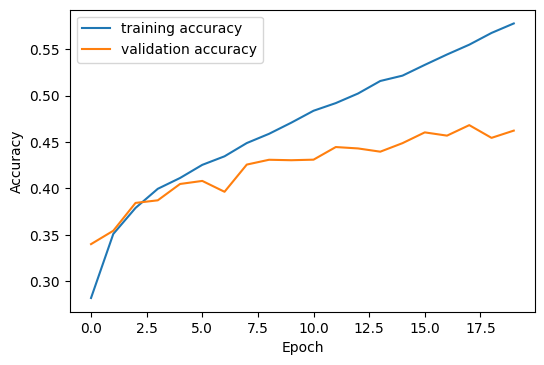

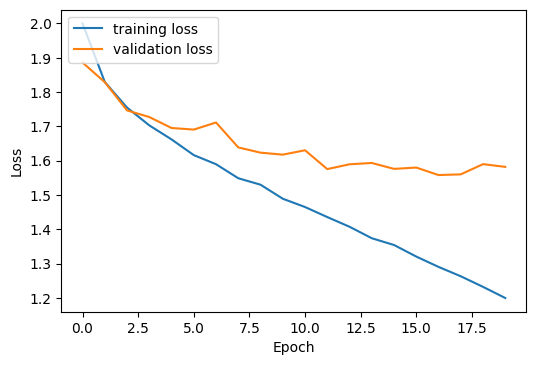

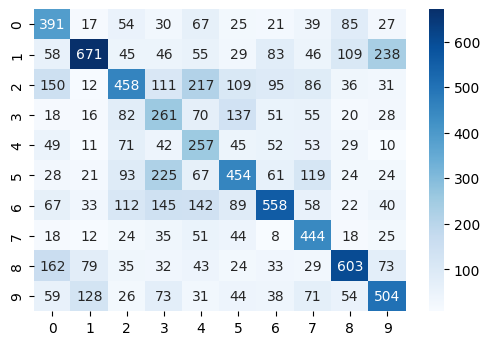

313/313 - 1s - loss: 1.5721 - accuracy: 0.4601 - 1s/epoch - 4ms/step
1250/1250 - 4s - loss: 1.1384 - accuracy: 0.6025 - 4s/epoch - 3ms/step
accuracy on test data: 0.460099995136261
loss on test data: 1.5720771551132202
f1_score on test data: 0.4542707426953288
recall on test data: 0.4601
presicion on test data: 0.4656752302962992


In [19]:
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(fit_history.history['accuracy'], label='training accuracy')
plt.plot(fit_history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.4, 1])
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(fit_history.history['loss'], label='training loss')
plt.plot(fit_history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0, 2])
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(6, 4), dpi=100)
z=model.predict(test_img_pca)
pred=np.argmax(z,axis=1)
y_label=np.argmax(test_label,axis=1)
cm = confusion_matrix(pred, y_label)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#disp.plot(cmap=plt.cm.Blues)
sns.heatmap(cm,cmap="Blues",annot=True,fmt="d")
plt.show()

# calculate loss and accuracy on test data and print it
test_loss, test_acc = model.evaluate(test_img_pca, test_label, verbose=2)
train_loss, train_acc = model.evaluate(train_img_pca,  train_label, verbose=2)
precision = precision_score(y_label,pred,average='weighted')
recall = recall_score(y_label,pred,average='weighted')
f1 = f1_score(y_label,pred,average='weighted')
print("accuracy on test data:",test_acc)
print("loss on test data:",test_loss)
print("f1_score on test data:",f1)
print("recall on test data:",recall)
print("presicion on test data:",precision)
#print("accuracy on train data:",train_acc)
#print("loss on train data:",train_loss)

# PART B

In [23]:
input_img = Input(shape=(1024,))
encoded1 = layers.Dense(1024, activation='relu')(input_img)
encoded2 = layers.Dense(77, activation='relu')(encoded1)
decoded1 = layers.Dense(512, activation='relu')(encoded2)
decoded2 = layers.Dense(1024, activation=None)(decoded1)
autoencoder = Model(input_img, decoded2)
opt = SGD(learning_rate=0.02, momentum=0.9)
autoencoder.compile(optimizer=opt, loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_12 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_13 (Dense)            (None, 77)                78925     
                                                                 
 dense_14 (Dense)            (None, 512)               39936     
                                                                 
 dense_15 (Dense)            (None, 1024)              525312    
                                                                 
Total params: 1,693,773
Trainable params: 1,693,773
Non-trainable params: 0
_________________________________________________________________


In [24]:
autoencoder.fit(train_data,train_data,
                epochs=70,
                batch_size=64,
                shuffle=False)
# Encoder
encoder = Model(input_img, encoded2)
encoded_imgs = encoder.predict(train_data)


Epoch 1/70
625/625 [==============================] - 3s 4ms/step - loss: 0.0592
Epoch 2/70
625/625 [==============================] - 3s 4ms/step - loss: 0.0364
Epoch 3/70
625/625 [==============================] - 3s 5ms/step - loss: 0.0316
Epoch 4/70
625/625 [==============================] - 3s 5ms/step - loss: 0.0285
Epoch 5/70
625/625 [==============================] - 3s 4ms/step - loss: 0.0267
Epoch 6/70
625/625 [==============================] - 3s 4ms/step - loss: 0.0253
Epoch 7/70
625/625 [==============================] - 3s 4ms/step - loss: 0.0241
Epoch 8/70
625/625 [==============================] - 3s 4ms/step - loss: 0.0230
Epoch 9/70
625/625 [==============================] - 3s 4ms/step - loss: 0.0220
Epoch 10/70
625/625 [==============================] - 3s 4ms/step - loss: 0.0211
Epoch 11/70
625/625 [==============================] - 3s 4ms/step - loss: 0.0203
Epoch 12/70
625/625 [==============================] - 3s 4ms/step - loss: 0.0197
Epoch 13/70
625/625 [====

In [25]:
encoded_imgs = encoder.predict(train_data)
encoded_test = encoder.predict(test_data)
encoded_valid = encoder.predict(valid_data)

In [26]:
model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=(77,)))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1024)              79872     
                                                                 
 dense_17 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_18 (Dense)            (None, 512)               524800    
                                                                 
 dense_19 (Dense)            (None, 10)                5130      
                                                                 
Total params: 1,659,402
Trainable params: 1,659,402
Non-trainable params: 0
_________________________________________________________________


In [27]:
# training the model
start_time=time.time()
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
fit_history = model.fit(encoded_imgs, train_label, epochs=40,
                    validation_data=(encoded_valid, valid_label), batch_size=128)
stop_time=time.time()
print("\n training time:",stop_time-start_time)

Epoch 1/40
313/313 [==============================] - 3s 7ms/step - loss: 2.1090 - accuracy: 0.2318 - val_loss: 2.0036 - val_accuracy: 0.2850
Epoch 2/40
313/313 [==============================] - 2s 7ms/step - loss: 1.9646 - accuracy: 0.2966 - val_loss: 1.9611 - val_accuracy: 0.2947
Epoch 3/40
313/313 [==============================] - 2s 7ms/step - loss: 1.9126 - accuracy: 0.3123 - val_loss: 1.9161 - val_accuracy: 0.3215
Epoch 4/40
313/313 [==============================] - 2s 6ms/step - loss: 1.8815 - accuracy: 0.3276 - val_loss: 1.9116 - val_accuracy: 0.3265
Epoch 5/40
313/313 [==============================] - 2s 6ms/step - loss: 1.8507 - accuracy: 0.3378 - val_loss: 1.8403 - val_accuracy: 0.3438
Epoch 6/40
313/313 [==============================] - 2s 7ms/step - loss: 1.8340 - accuracy: 0.3442 - val_loss: 1.8447 - val_accuracy: 0.3414
Epoch 7/40
313/313 [==============================] - 2s 6ms/step - loss: 1.8017 - accuracy: 0.3598 - val_loss: 1.7974 - val_accuracy: 0.3631
Epoch 

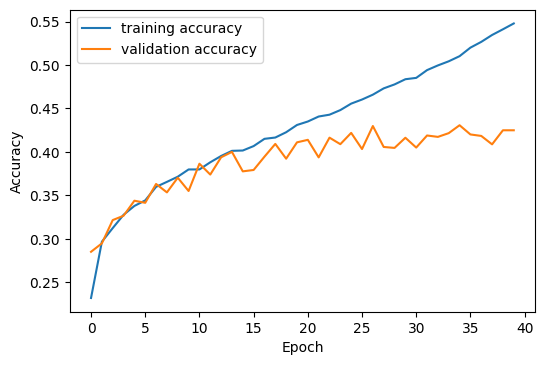

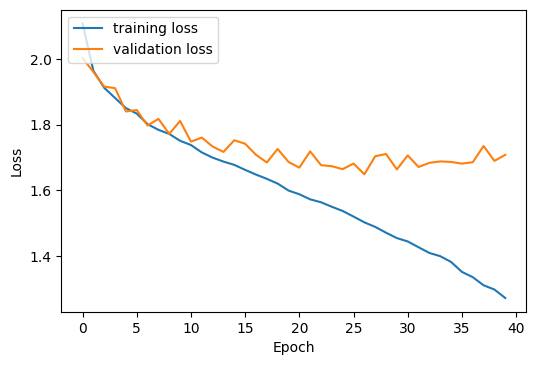

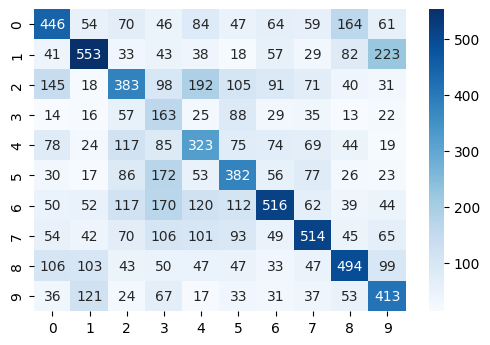

313/313 - 1s - loss: 1.6991 - accuracy: 0.4187 - 936ms/epoch - 3ms/step
1250/1250 - 4s - loss: 1.2127 - accuracy: 0.5753 - 4s/epoch - 3ms/step
accuracy on test data: 0.4187000095844269
loss on test data: 1.6990770101547241
f1_score on test data: 0.41208502441761996
recall on test data: 0.4187
presicion on test data: 0.416375205683395


In [28]:
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(fit_history.history['accuracy'], label='training accuracy')
plt.plot(fit_history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.4, 1])
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(fit_history.history['loss'], label='training loss')
plt.plot(fit_history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0, 2])
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(6, 4), dpi=100)
z=model.predict(encoded_test)
pred=np.argmax(z,axis=1)
y_label=np.argmax(test_label,axis=1)
cm = confusion_matrix(pred, y_label)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#disp.plot(cmap=plt.cm.Blues)
sns.heatmap(cm,cmap="Blues",annot=True,fmt="d")
plt.show()

# calculate loss and accuracy on test data and print it
test_loss, test_acc = model.evaluate(encoded_test, test_label, verbose=2)
train_loss, train_acc = model.evaluate(encoded_imgs,  train_label, verbose=2)
precision = precision_score(y_label,pred,average='weighted')
recall = recall_score(y_label,pred,average='weighted')
f1 = f1_score(y_label,pred,average='weighted')
print("accuracy on test data:",test_acc)
print("loss on test data:",test_loss)
print("f1_score on test data:",f1)
print("recall on test data:",recall)
print("presicion on test data:",precision)
#print("accuracy on train data:",train_acc)
#print("loss on train data:",train_loss)

# PART C

In [2]:
import pandas as pd
import numpy as np
import keras
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
drive.mount('/content/drive')
%cd /content/drive/My Drive/HW2_deep/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/HW2_deep


In [3]:
df = pd.read_csv("data.csv")
df=df[df["price"]<=10000000]

In [4]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].apply(lambda date:date.month)
df['year'] = df['date'].apply(lambda date:date.year)
df['day']=df['date'].apply(lambda date:date.day)
y = df.price
X = df.drop(columns=["price"], axis=1)

In [5]:
df=df.drop("date",axis=1)

In [6]:
cat_cols=["street", "city","statezip","country"]
num_cols=list(df.columns.values)
num_cols=list(set(num_cols)-set(cat_cols))
X_categorical_df = pd.get_dummies(X[cat_cols], columns=cat_cols)
#num_cols.remove("price")

In [7]:
cm=df.corr()

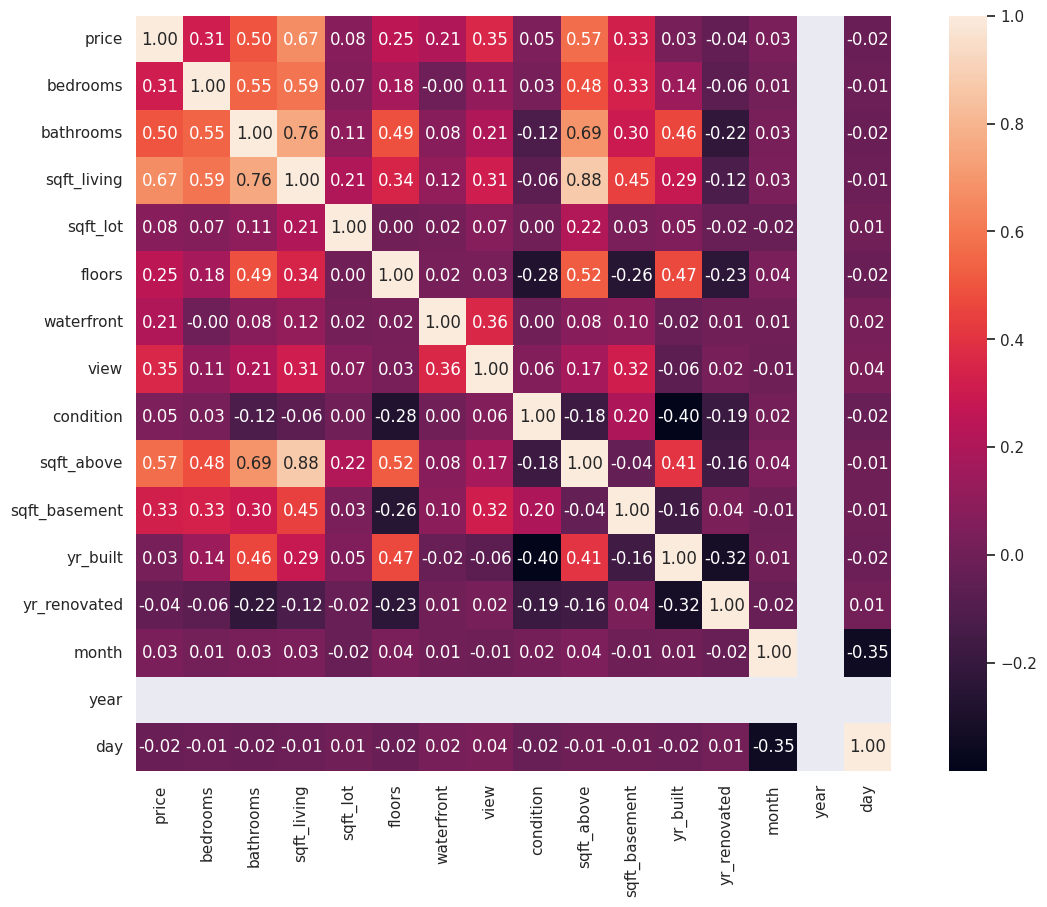

In [8]:
plt.figure(figsize=(15, 10), dpi=100)
sns.set(font_scale=1)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                 )

# PART D

In [9]:
num_cols.remove("price")
X_final = X[num_cols]
X_final = X_final.join(X_categorical_df)

In [10]:
from sklearn import preprocessing
X_final[num_cols] = preprocessing.StandardScaler().fit_transform(X_final[num_cols])

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=420)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=420)

In [12]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
#plt.bar([x for x in range(len(importance))], importance)
#plt.show()

Feature: 0, Score: -50979.37891
Feature: 1, Score: -15693.85466
Feature: 2, Score: 155993974082205568.00000
Feature: 3, Score: -225165.84276
Feature: 4, Score: 61451.69224
Feature: 5, Score: 75163.60546
Feature: 6, Score: -41066.55049
Feature: 7, Score: 3324871.49819
Feature: 8, Score: -692.36985
Feature: 9, Score: 23417547257020.85938
Feature: 10, Score: 105799838421764.17188
Feature: 11, Score: -132337.19855
Feature: 12, Score: 83974692765814592.00000
Feature: 13, Score: -41285190165433120.00000
Feature: 14, Score: -174268762844259744.00000
Feature: 15, Score: 427489669114520.18750
Feature: 16, Score: 4673689931443329.00000
Feature: 17, Score: -312940315719983.18750
Feature: 18, Score: -312940315806760.06250
Feature: 19, Score: -1564241696179571.25000
Feature: 20, Score: 65955558762896.21875
Feature: 21, Score: -110072965773601.04688
Feature: 22, Score: -110072965970107.93750
Feature: 23, Score: 279136459460740.50000
Feature: 24, Score: 878941804540240.75000
Feature: 25, Score: 11552

In [13]:
from copy import deepcopy
# sort features by importance
bb=deepcopy(importance)
bb=abs(bb)
bb.sort()
bb=np.flip(bb)
zz=[np.where(abs(importance)==bb[i]) for i in range(14) ]
zxc=[x[0][0] for x in zz]
feats=[X_train.iloc[:,i].name for i in zxc] 

<function matplotlib.pyplot.tight_layout>

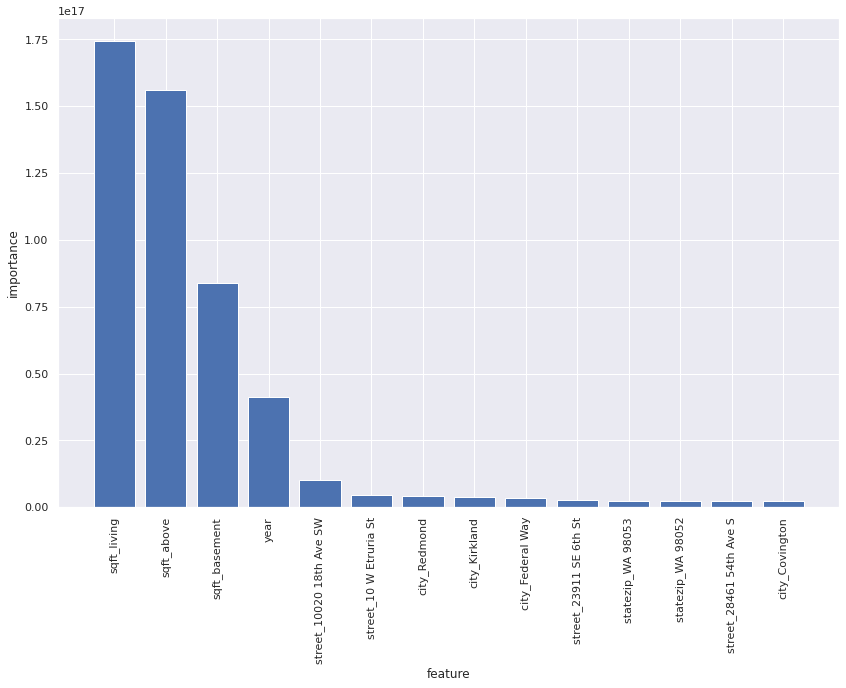

In [14]:
plt.figure(figsize=(14,9))
plt.bar(feats[0:14],bb[0:14])
plt.ylabel("importance")
plt.xlabel("feature")
plt.xticks(rotation='vertical')
plt.tight_layout

In [15]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00244
Feature: 1, Score: 0.01461
Feature: 2, Score: 0.02373
Feature: 3, Score: 0.00261
Feature: 4, Score: 0.00861
Feature: 5, Score: 0.06100
Feature: 6, Score: 0.00582
Feature: 7, Score: 0.01722
Feature: 8, Score: 0.00782
Feature: 9, Score: 0.00206
Feature: 10, Score: 0.02119
Feature: 11, Score: 0.01043
Feature: 12, Score: 0.00578
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.48993
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00002
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

In [16]:
from copy import deepcopy
# sort features by importance
bb=deepcopy(importance)
bb=abs(bb)
bb.sort()
bb=np.flip(bb)
zz=[np.where(abs(importance)==bb[i]) for i in range(14) ]
zxc=[x[0][0] for x in zz]
feats=[X_train.iloc[:,i].name for i in zxc] 

<function matplotlib.pyplot.tight_layout>

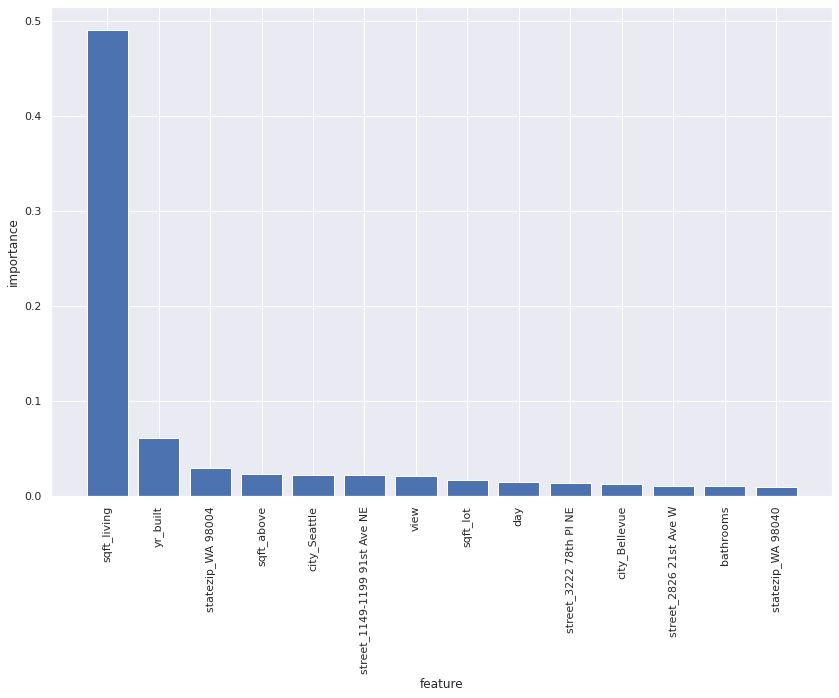

In [17]:
plt.figure(figsize=(14,9))
plt.bar(feats,bb[0:14])
plt.ylabel("importance")
plt.xlabel("feature")
plt.xticks(rotation='vertical')
plt.tight_layout

In [18]:
from sklearn.utils.extmath import randomized_svd
U, S, Vt = randomized_svd(
                X_train.values,
                n_components=100,
                n_iter="auto",
                random_state=None,
            )

In [19]:
eigs=S**2/(3126-1)

[0.22879060878012256, 0.12119819638689568, 0.08158827531072006, 0.07064733239238266, 0.0701384162829825, 0.06633700495740563, 0.049152343163530635, 0.04388412060312753, 0.03857724040186001, 0.03804204059024587, 0.02774334379388711, 0.025641890906316914, 0.023352200252389876, 0.013481606027029129, 0.006889986293643545, 0.004793282453305009, 0.004564746923962139, 0.004213585873398057, 0.0036359033153890567, 0.0033803985850279395, 0.0032741760096248957, 0.003104973376842234, 0.002936758276196278, 0.0027565491608038243, 0.0025404604941938833, 0.0023458232223382146, 0.002224042123111827, 0.0020128872178478228, 0.001707558683820354, 0.0016510330528642478, 0.0016163754896358405, 0.0015895948273867294, 0.0014666826846962276, 0.0014321816008261304, 0.0014072556679346074, 0.0013908698569622961, 0.0013403794948233818, 0.0013196256495970487, 0.0012781801221935102, 0.0012564765412609936, 0.0012389693943004338, 0.0012183974190702767, 0.0011599658335187946, 0.001103549223647908, 0.0010848297507680868

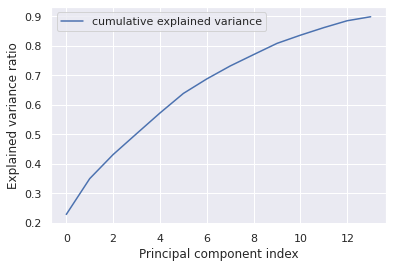

In [20]:
var_exp = [(i / sum(eigs)) for i in sorted(eigs, reverse=True)]
print(var_exp)
cum_var_exp = np.cumsum(var_exp)

plt.plot(range(14), cum_var_exp[0:14], 
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [21]:
X_train = X_train@Vt.T
X_test = X_test@Vt.T
X_val = X_val@Vt.T

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape,y_val.shape, X_val.shape

((3126, 100), (920, 100), (3126,), (920,), (552,), (552, 100))

In [23]:
model = models.Sequential()
model.add(layers.Dense(60,activation='relu'))
model.add(layers.Dense(60,activation='relu'))
model.add(layers.Dense(60,activation='relu'))
#model.add(layers.Dense(20,activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='Adam',loss='mae')
model.fit(x=X_train,y=y_train,
          validation_data=(X_val,y_val),
          batch_size=128,epochs=200)
model.summary()
loss_df = pd.DataFrame(model.history.history)

Epoch 1/200
25/25 [==============================] - 1s 13ms/step - loss: 544671.5000 - val_loss: 529667.0000
Epoch 2/200
25/25 [==============================] - 0s 5ms/step - loss: 544664.0625 - val_loss: 529650.5625
Epoch 3/200
25/25 [==============================] - 0s 5ms/step - loss: 544628.4375 - val_loss: 529581.3125
Epoch 4/200
25/25 [==============================] - 0s 5ms/step - loss: 544501.3750 - val_loss: 529361.0625
Epoch 5/200
25/25 [==============================] - 0s 5ms/step - loss: 544144.8125 - val_loss: 528796.8750
Epoch 6/200
25/25 [==============================] - 0s 6ms/step - loss: 543316.2500 - val_loss: 527588.5625
Epoch 7/200
25/25 [==============================] - 0s 6ms/step - loss: 541655.1875 - val_loss: 525318.6875
Epoch 8/200
25/25 [==============================] - 0s 5ms/step - loss: 538695.8750 - val_loss: 521437.2812
Epoch 9/200
25/25 [==============================] - 0s 5ms/step - loss: 533853.1250 - val_loss: 515295.4062
Epoch 10/200
25/25

MAE: 90543.96511117065
MSE: 28430505855.23321
RMSE: 168613.48064503388
VarScore: 0.7809359107820648


Text(0, 0.5, 'predicted price')

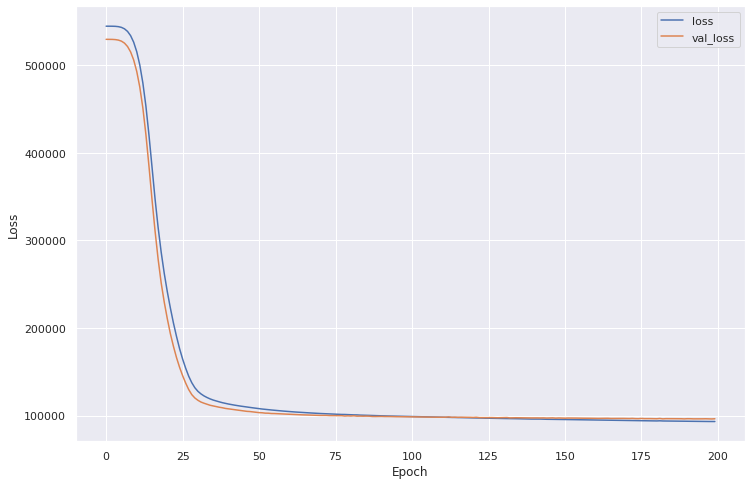

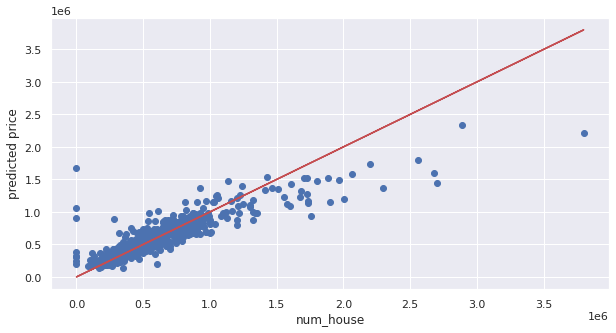

In [24]:
loss_df.plot(figsize=(12,8))
plt.xlabel("Epoch")
plt.ylabel("Loss")
y_pred = model.predict(X_test)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('VarScore:',metrics.explained_variance_score(y_test,y_pred))# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred)
# Perfect predictions
plt.plot(y_test,y_test,'r')
plt.xlabel("num_house")
plt.ylabel("predicted price")